In [1]:
# The code is developed for the paper "Customer Segmentation Applied On RFM-ID Model"

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from minisom import MiniSom
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logsumexp

# Loading Data 

~ Data Description ~

InvoiceNo(Nominal): A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

StockCode(Nominal): Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. 

Description(String):  Product (item) name. 

Quantity(Numeric): The quantities of each product (item) per transaction.

InvoiceDate(Numeric): Invoice date and time. The day and time when a transaction was generated. 

UnitPrice(Numeric): Product price per unit in sterling (Â£). 

CustomerID(Nominal): A 5-digit integral number uniquely assigned to each customer. 

Country(Nominal): The name of the country where a customer resides.



In [3]:
df_dict = pd.read_excel('./data/online_retail.xlsx', sheet_name=None) # contains two excel sheets

In [4]:
df_1 = df_dict['Year 2009-2010']
df_2 = df_dict['Year 2010-2011']

df_c = pd.concat([df_1, df_2]) 

In [5]:
print(f"Number of records: {df_c.shape[0]}")

Number of records: 1067371


In [6]:
df_c.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [7]:
df_c.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [8]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


# Pre-processing

## Removing Null values

In [9]:
null_values_percentage = round(100*(df_c.isnull().sum())/len(df_c), 2)

In [10]:
null_values_percentage

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [11]:
# As we see custoemr ID has around 22% percent of null values. We are will drop these columns.

In [12]:
df_proc = df_c.dropna() # pre-processed data frame (data_proc)

In [13]:
df_proc.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,824364.000000,824364,824364.000000,824364.000000
mean,12.414574,2011-01-01 22:29:28.042054144,3.676800,15324.638504
min,-80995.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-07-06 11:58:00,1.250000,13975.000000
50%,5.000000,2010-12-03 14:26:00,1.950000,15255.000000
75%,12.000000,2011-07-27 15:14:00,3.750000,16797.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,188.976099,NaN,70.241388,1697.464450


## Removing Negative values

In [14]:
df_proc = df_proc[~df_proc["Invoice"].str.contains("C", na = False)]

## Removing Outliers

In [15]:
df_proc[["Quantity", "Price"]]

,Quantity,Price
0,12,6.95
1,12,6.75
2,12,6.75
3,48,2.10
4,24,1.25
...,...,...
541905,6,2.10
541906,4,4.15
541907,4,4.15
541908,3,4.95


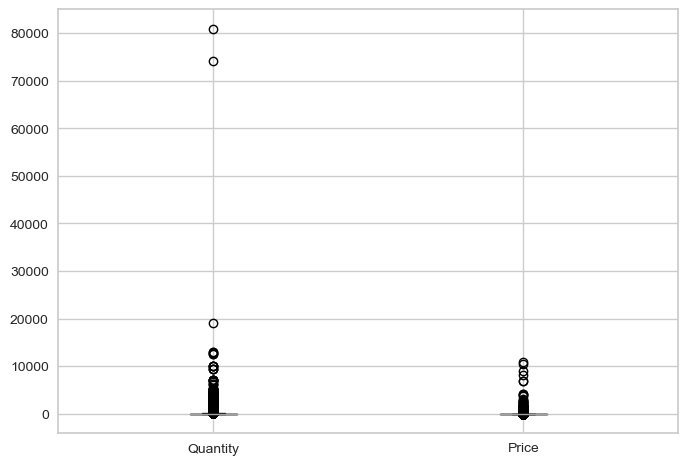

In [16]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [17]:
# As we see, Quantity and Price have outliers. So, we will remove them.

In [18]:
# Removing outliers from the Quantity attribute
Q1 = df_proc.Quantity.quantile(0.25)
Q3 = df_proc.Quantity.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Quantity>lower_limit)&(df_proc.Quantity<upper_limit)]


In [19]:
# Removing outliers from the Price attribute
Q1 = df_proc.Price.quantile(0.25)
Q3 = df_proc.Price.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Price>lower_limit)&(df_proc.Price<upper_limit)]


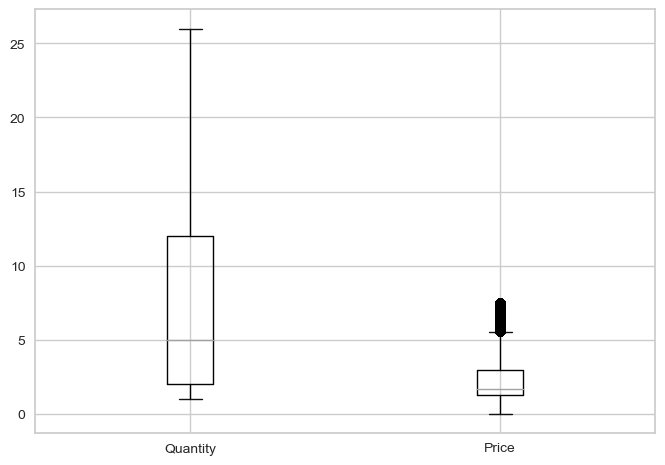

In [20]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [21]:
df_proc.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,686023.000000,686023,686023.000000,686023.000000
mean,7.299531,2011-01-02 12:08:08.844630784,2.269788,15362.101306
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-07-06 13:55:00,1.250000,14019.000000
50%,5.000000,2010-12-03 11:35:00,1.690000,15311.000000
75%,12.000000,2011-07-31 14:29:00,2.950000,16841.000000
max,26.000000,2011-12-09 12:50:00,7.490000,18287.000000
std,6.692578,NaN,1.599637,1694.422894


# RFMVD Score

R(Recenecy): How recently did the customer purchase?

F(Frequency): How often do they purchase?

M(Monetary): How much do they spend?

V(Variety): How many products sold by each customer?

D(Duration): How much time between each two transactions?

In [22]:
# Numbber of descriptions per product for each StockCode.
df_proc.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
21955,4
22346,4
22345,4
22344,4
23196,4


In [23]:
# From the above table we can see that each StockCode has more than one description. This is maybe because of non-standard human input.

## RFM

In [24]:
# Recency

# Max date
df_proc['InvoiceDate'] = pd.to_datetime(df_proc['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = df_proc['InvoiceDate'].max()
max_date

# Different between max date and the transaction date
df_proc['Diff'] = max_date - df_proc['InvoiceDate']

# Last transaction date for each customer
rfm_r = df_proc.groupby('Customer ID')['Diff'].min().reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.columns =  ['Customer ID', 'Recency']
rfm_r.head(10)

,Customer ID,Recency
0,12346.0,528
1,12347.0,1
2,12348.0,248
3,12349.0,18
4,12350.0,309
5,12351.0,374
6,12352.0,35
7,12353.0,203
8,12354.0,231
9,12355.0,213


In [25]:
# Frequency
rfm_f = df_proc.groupby('Customer ID')['Invoice'].count().reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head(10)


,Customer ID,Frequency
0,12346.0,33
1,12347.0,234
2,12348.0,26
3,12349.0,137
4,12350.0,16
5,12351.0,20
6,12352.0,83
7,12353.0,22
8,12354.0,40
9,12355.0,29


In [26]:
# Monetary 
df_proc['Total'] = df_proc['Price'] * df_proc['Quantity']
rfm_m = df_proc.groupby('Customer ID')['Total'].mean().reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head(10)

,Customer ID,Monetary
0,12346.0,11.298788
1,12347.0,19.397009
2,12348.0,12.013846
3,12349.0,19.124380
4,12350.0,18.400000
5,12351.0,14.409000
6,12352.0,17.614337
7,12353.0,15.775455
8,12354.0,17.067250
9,12355.0,22.624483


In [27]:
# Creating the RFM data frame.
rfm = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_m, on='Customer ID', how='inner')
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,528,33,11.298788
1,12347.0,1,234,19.397009
2,12348.0,248,26,12.013846
3,12349.0,18,137,19.124380
4,12350.0,309,16,18.400000
5,12351.0,374,20,14.409000
6,12352.0,35,83,17.614337
7,12353.0,203,22,15.775455
8,12354.0,231,40,17.067250
9,12355.0,213,29,22.624483


## VD

In [28]:
# Variety
def div(x: pd.Series):
    u = x.nunique()
    return u

rfm_v = df_proc.groupby('Customer ID')['StockCode'].agg([div]).reset_index()
rfm_v.columns = ['Customer ID', 'Variety']
rfm_v.head(10)

,Customer ID,Variety
0,12346.0,26
1,12347.0,119
2,12348.0,21
3,12349.0,110
4,12350.0,16
5,12351.0,20
6,12352.0,60
7,12353.0,21
8,12354.0,40
9,12355.0,29


In [29]:
# Duration

import statistics
def duration(x: pd.Series):
    m = []
    x = pd.to_datetime(x, format='%d-%m-%Y %H:%M')
    x.sort_values(inplace=True)
    # x.add(max_date)
    # print(x.head(10))
    # print(x.iloc[0])
    for i in range(1, len(x)-1):
        diff =  x.iloc[i] - x.iloc[i - 1]
        m.append(diff.days)
    return statistics.mean(m) if m else 0 

# df_proc_u = df_proc['InvoiceDate'].combine
rfm_d= df_proc.groupby('Customer ID')['InvoiceDate'].agg([duration]).reset_index()
rfm_d.columns = ['Customer ID', 'Duration']
rfm_d.head(10)



,Customer ID,Duration
0,12346.0,6.193548
1,12347.0,1.719828
2,12348.0,4.958333
3,12349.0,4.222222
4,12350.0,0.000000
5,12351.0,0.000000
6,12352.0,4.358025
7,12353.0,10.200000
8,12354.0,0.000000
9,12355.0,13.074074


In [30]:
# Ceating the RFMVD data frame.
vd = pd.merge(rfm_v, rfm_d, on='Customer ID', how='inner')

rfmvd = pd.merge(rfm, vd, on='Customer ID', how='inner')
rfmvd.describe()

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
count,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000
mean,15318.222437,200.019021,120.821240,16.460336,74.122754,5.173648
std,1714.837549,208.931814,311.775018,11.570702,104.713773,13.808918
min,12346.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,13837.250000,25.000000,18.000000,9.142367,17.000000,0.000000
50%,15318.500000,94.500000,47.000000,15.861204,40.000000,1.932077
75%,16801.750000,379.000000,123.000000,19.175765,92.750000,5.215505
max,18287.000000,738.000000,12052.000000,166.800000,2219.000000,471.000000


In [31]:
rfmvd.corr()

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
Customer ID,1.000000,0.028031,0.009918,-0.098490,0.007932,-0.005307
Recency,0.028031,1.000000,-0.214235,0.014946,-0.321802,-0.103892
Frequency,0.009918,-0.214235,1.000000,-0.121369,0.867775,-0.081310
Monetary,-0.098490,0.014946,-0.121369,1.000000,-0.216600,0.238225
Variety,0.007932,-0.321802,0.867775,-0.216600,1.000000,-0.126963
Duration,-0.005307,-0.103892,-0.081310,0.238225,-0.126963,1.000000


## Scaling

In [32]:
scaler = StandardScaler()
# scaler =  MinMaxScaler()
rfmvd_tmp = rfmvd[['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']]
rfmvd_scaled = pd.DataFrame(scaler.fit_transform(rfmvd_tmp))
rfmvd_scaled.columns =['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']
rfmvd_scaled.head(20)

,Recency,Frequency,Monetary,Variety,Duration
0,1.569937,-0.281706,-0.446127,-0.459605,0.073865
1,-0.952639,0.363046,0.253825,0.428608,-0.250137
2,0.229669,-0.304160,-0.384323,-0.507359,-0.015594
3,-0.871265,0.051897,0.230261,0.342652,-0.068905
4,0.521656,-0.336238,0.167651,-0.555112,-0.374693
5,0.832790,-0.323407,-0.177303,-0.516909,-0.374693
6,-0.789892,-0.121320,0.099744,-0.134882,-0.059070
7,0.014269,-0.316991,-0.059196,-0.507359,0.364025
8,0.148296,-0.259252,0.052457,-0.325896,-0.374693
9,0.062136,-0.294537,0.532784,-0.430953,0.572175


# Segmentation Algorithms

## K-means

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

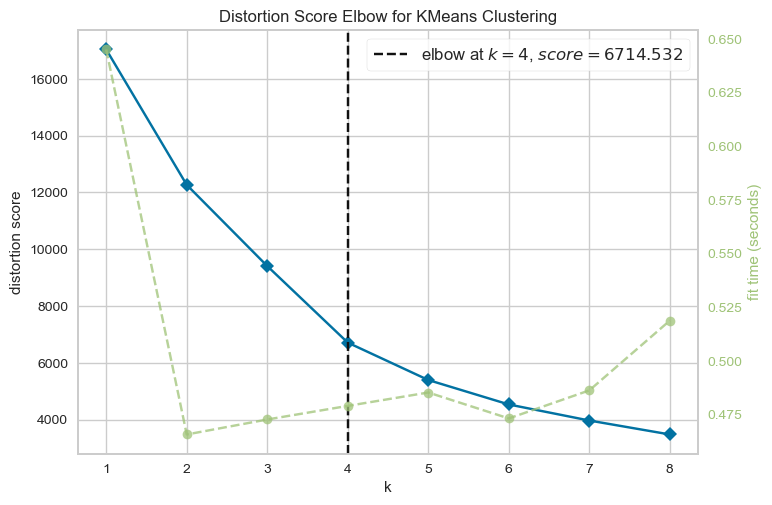

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
# RFM
vars = ['Recency', 'Frequency', 'Monetary']
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(rfmvd_scaled[vars])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [34]:
n = 4 # number of clusters

In [35]:
%%timeit -r1 -n1
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


470 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [36]:
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=500, n_clusters=4, random_state=1)

In [37]:
# RFM

cluster_labels = kmeans.labels_
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



For n_clusters=4, the silhouette score is 0.4628748478851776
For n_clusters=4, the calinski score is 2906.7628789400237
For n_clusters=4, the davis_bouldin score is 0.6931877049709919


In [38]:
kmeans.cluster_centers_

array([[ 1.25504763, -0.25461018, -0.19726448],
       [-0.64198605,  0.11750272, -0.15134397],
       [-0.95359611, 24.01102582, -0.70637992],
       [ 0.04421009, -0.25967771,  3.06463527]])

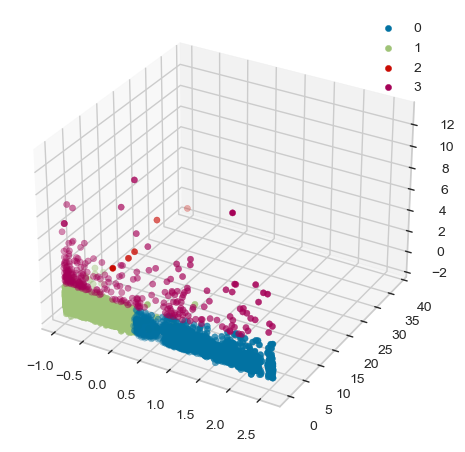

In [39]:
# RFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')

#plotting the results:
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Labels == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Monetary'], label = i, zorder=1)

 # plotting centroids
# ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
#                 s=1, linewidths=10, color='b', label='centroid', zorder=100)
ax.legend()
plt.show()

In [40]:
centroids

array([[ 1.25504763, -0.25461018, -0.19726448],
       [-0.64198605,  0.11750272, -0.15134397],
       [-0.95359611, 24.01102582, -0.70637992],
       [ 0.04421009, -0.25967771,  3.06463527]])

## DBSCAN

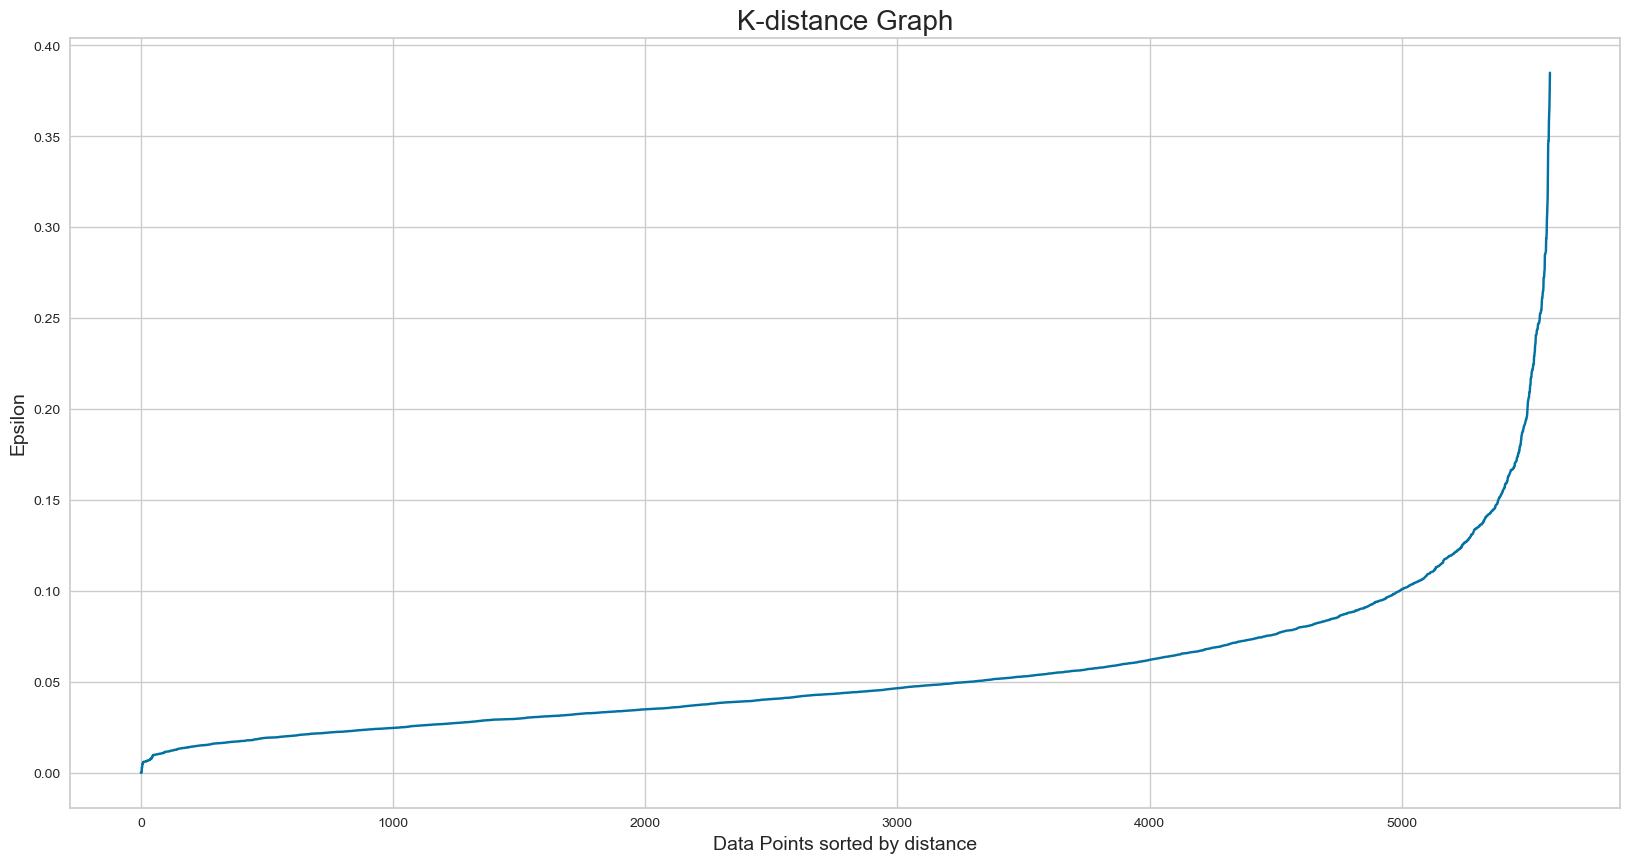

In [83]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(rfmvd_scaled[vars])
distances, indices = nbrs.kneighbors(rfmvd_scaled[vars])

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [84]:
e = 0.4
s = 6

In [85]:
%%timeit -r1 -n1
dbscan = DBSCAN(eps=e, min_samples=s)
dbscan.fit(rfmvd_scaled[vars])

136 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
dbscan = DBSCAN(eps=e, min_samples=s)
dbscan.fit(rfmvd_scaled[vars])

DBSCAN(eps=0.4, min_samples=6)

In [87]:
# RFM

cluster_labels = dbscan.labels_
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For e={0}, s={1} the silhouette score is {2}".format(e, s, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For e={0}, s={1} the calinski score is {1}".format(e, s, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For e={0}, s={1} the davis_bouldin score is {1}".format(e, s, db_index))



For e=0.4, s=6 the silhouette score is 0.5633462986229713
For e=0.4, s=6 the calinski score is 6
For e=0.4, s=6 the davis_bouldin score is 6


In [88]:
rfmvd_scaled_DBSCAN = rfmvd_scaled[rfmvd_scaled.Labels == 0]

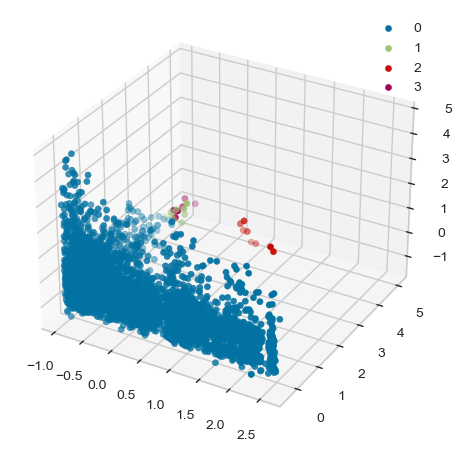

In [89]:
# RFM clustering graph
u_labels = np.unique(cluster_labels[1:])
ax = plt.axes(projection='3d')
    
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Labels == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Monetary'], label = i)
ax.legend()
plt.show()

# Heirarchical clustring

In [90]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


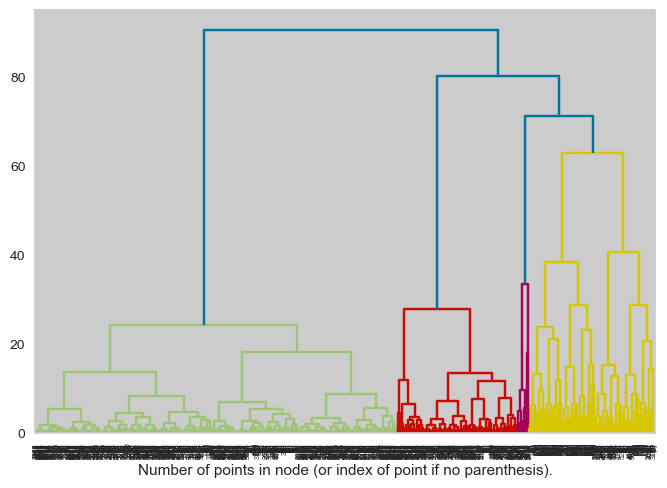

In [91]:
agl = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agl.fit(rfmvd_scaled)
plot_dendrogram(agl, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [92]:
%%timeit -r1 -n1
agl = AgglomerativeClustering(n_clusters=4)
agl.fit(rfmvd_scaled[vars])

498 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
agl = AgglomerativeClustering(n_clusters=4)
agl.fit(rfmvd_scaled[vars])

AgglomerativeClustering(n_clusters=4)

In [94]:
cluster_labels = agl.labels_
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))

For n_clusters=3, the silhouette score is 0.35760880391105154
For n_clusters=3, the calinski score is 2779.8194316431914
For n_clusters=3, the davis_bouldin score is 0.9860705157754501


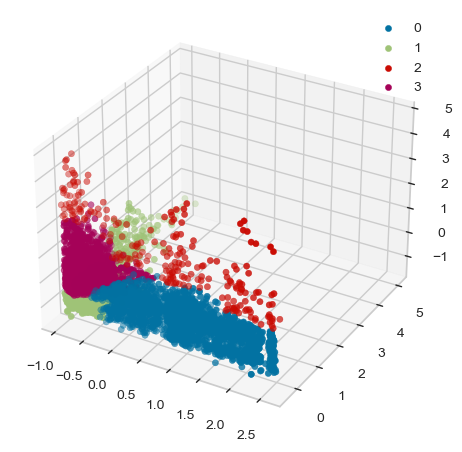

In [95]:
# DFM clustering graph
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')
    
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Labels == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Monetary'], label = i)
ax.legend()
plt.show()

# Comparision
4472.584335852707
For n_clusters=4, the davis_bouldin score is 0.670

| Model Name | Silhouette | Calinski | davies_bouldin | Time |
|:--------:|:--------:|:--------:| :--------: |:--------:|
|  K-means |  0.5846  | 4472.58     |   0.670    |   458 ms       |
|  DBSCAN  |  0.64   |  1000   |  1000          |   242 ms       | 
|  Herarchical Clustring|  0.549 |  4100    |   0.73       | 506 ms |

Text(0.5, 1.0, 'Silhouette scores')

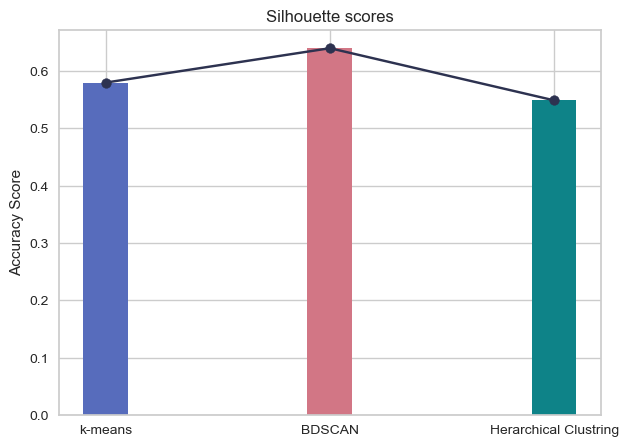

In [57]:
fig, ax = plt.subplots(figsize = (7, 5))

algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
Silhouette_scores = [0.58, 0.64, 0.549]

plt.bar(algorithms, Silhouette_scores, color =['#576CBC', '#D27685', '#0E8388'], 
        width = 0.2)
plt.scatter(algorithms, Silhouette_scores, color='#2D3250')
plt.plot(algorithms, Silhouette_scores, color='#2D3250')

width = 0.25  # the width of the bars
ax.set_ylabel('Accuracy Score')
ax.set_title('Silhouette scores')

Text(0.5, 1.0, 'Calinski scores')

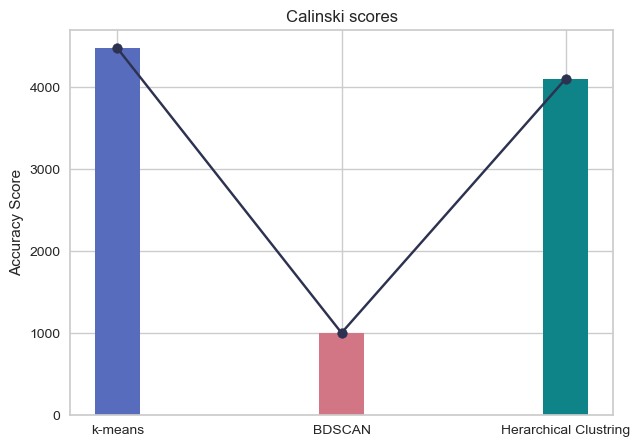

In [58]:
fig, ax = plt.subplots(figsize = (7, 5))

algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
Calinski_scores = [4472.58, 1000, 4100]
plt.bar(algorithms, Calinski_scores, color =['#576CBC', '#D27685', '#0E8388'], 
        width = 0.2)
plt.scatter(algorithms, Calinski_scores, color='#2D3250')
plt.plot(algorithms, Calinski_scores, color='#2D3250')

ax.set_ylabel('Accuracy Score')
ax.set_title('Calinski scores')

Text(0.5, 1.0, 'Davis bouldin scores')

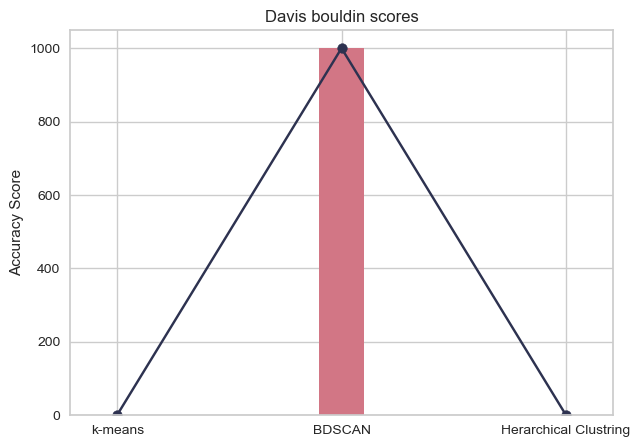

In [59]:
fig, ax = plt.subplots(figsize = (7, 5))

algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
Davis_scores = [0.670, 1000, 0.73]
# Maybe neet to be sacled.
plt.bar(algorithms, Davis_scores, color =['#576CBC', '#D27685', '#0E8388'], 
        width = 0.2)
plt.scatter(algorithms, Davis_scores, color='#2D3250')
plt.plot(algorithms, Davis_scores, color='#2D3250')

ax.set_ylabel('Accuracy Score')
ax.set_title('Davis bouldin scores')

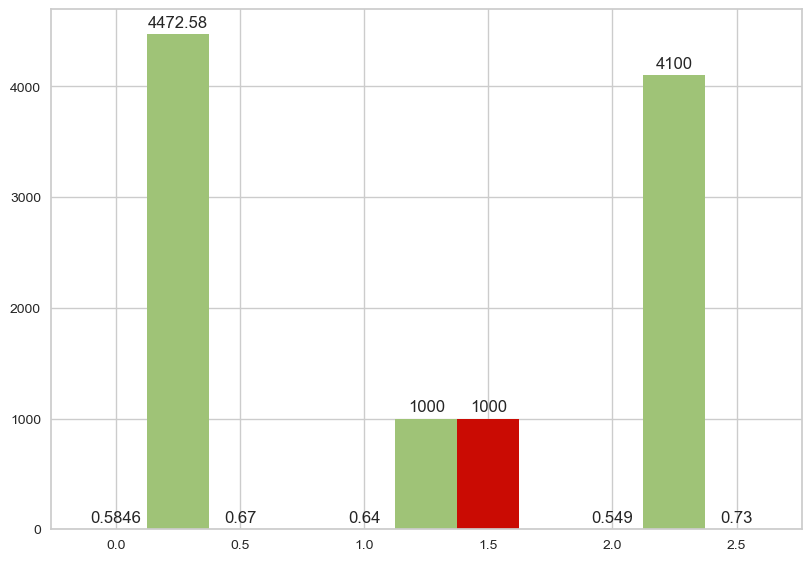

In [60]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
scores = {
    'Silhouette_scores': [0.5846, 0.64, 0.549],
    'Calinski_scores': [4472.58, 1000, 4100 ],
    'Davis_scores': [0.670, 1000, 0.73],
}
algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
# Silhouette_scores = [0.5846, 0.64, 0.549]
# Calinski_scores = [4472.58, 1000, 4100]
# Davis_scores = [0.670, 1000, 0.73]
x = np.arange(len(algorithms))  # the label locations
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0
for alg, values in scores.items() :
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=alg)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Double Clustring

In [ ]:
n = 3
e = 0.8
s = 1000
double_cluster_df = pd.DataFrame()
centroids_n = []
for i in range(len(centroids)):
    kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
    rfm_i = rfmvd_scaled[vars].loc[rfmvd_scaled['Labels'] == i]
    kmeans.fit(rfm_i)
    # kmeans = AgglomerativeClustering(n_clusters=2)
    # kmeans.fit(rfm_i)
    labels = [l+(2*(i**2)) for l in kmeans.labels_] 
    sel_score = calinski_harabasz_score(rfm_i, labels)
    print(sel_score)
    if sel_score:
        rfm_i['Labels'] = labels
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)
    else:
        rfm_i['Labels'] = 2*(i**2)
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

# Clustring Over Intervals